# Advanced Latent Optimization Strategies

This notebook trains a small demo model on the sample polymer data (density target) and then explores `optimize_latent` strategies:
1. Data-driven initialization (seeds from descriptors)
2. Perturbation to escape local optima
3. Multi-restart for global search
4. Comparison of different starting strategies


In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    MLPEncoderConfig,
    RegressionTaskConfig,
    AutoEncoderTaskConfig,
    OptimizerConfig,
)

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Libraries loaded (device={device})")


✓ Libraries loaded (device=cpu)


## Train a quick model using sample polymer data

We load descriptors/targets from `samples/dynamic_task_suite_config.toml` paths, fit a small model on `density`, and reuse that model for latent optimization.


In [2]:
# If parquet support is missing, uncomment the next line in your environment:
# %pip install pandas pyarrow --quiet


Epoch 50: loss=0.0019
Epoch 100: loss=0.0011
Epoch 150: loss=0.0011
Epoch 200: loss=0.0010
Training complete. Samples used: 4096, input_dim=190


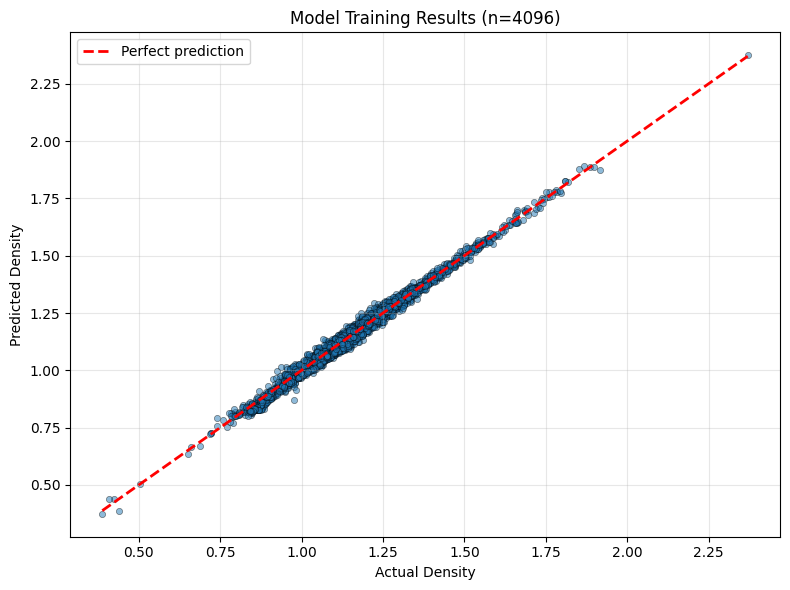


Training Set Metrics:
  MAE:  0.0151
  RMSE: 0.0187
  R²:   0.9885


In [9]:
from loguru import logger as fm_logger
fm_logger.disable("foundation_model")

descriptor_path = Path('../data/amorphous_polymer_FFDescriptor_20250730.parquet')
target_path = Path('../data/amorphous_polymer_non_PI_properties_20250730.parquet')
target_name = 'density'

descriptors = pd.read_parquet(descriptor_path)
properties = pd.read_parquet(target_path)[[target_name]]

# Merge and keep numeric descriptor columns
merged = descriptors.join(properties).dropna(subset=[target_name])
descriptor_cols = [c for c in descriptors.columns if pd.api.types.is_numeric_dtype(descriptors[c])]
X = torch.tensor(merged[descriptor_cols].values, dtype=torch.float32)
y = torch.tensor(merged[target_name].values, dtype=torch.float32).unsqueeze(1)

max_samples = 4096
if len(X) > max_samples:
    X = X[:max_samples]
    y = y[:max_samples]

X = X.to(device)
y = y.to(device)
input_dim = X.shape[1]
latent_dim = 128

encoder_config = MLPEncoderConfig(hidden_dims=[input_dim, 256, latent_dim], norm=True)
density_task = RegressionTaskConfig(
    name='density',
    data_column='density',
    dims=[latent_dim, 64, 32, 1],
    norm=True,
)
ae_task = AutoEncoderTaskConfig(
    name='reconstruction',
    data_column='__autoencoder__',
    dims=[latent_dim, 256, input_dim],
    norm=True,
)

model = FlexibleMultiTaskModel(
    encoder_config=encoder_config,
    task_configs=[density_task, ae_task],
    shared_block_optimizer=OptimizerConfig(lr=5e-3),
).to(device)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
optim = torch.optim.Adam(model.parameters(), lr=5e-3)

model.train()
for epoch in range(200):
    total = 0.0
    for batch_x, batch_y in loader:
        optim.zero_grad()
        # UPDATED: Use model's forward() which applies Tanh uniformly
        outputs = model(batch_x)
        pred = outputs['density']
        recon = outputs['reconstruction']
        loss = F.mse_loss(pred, batch_y) + F.mse_loss(recon, batch_x)
        loss.backward()
        optim.step()
        total += loss.item() * batch_x.size(0)
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}: loss={total / len(dataset):.4f}')

model.eval()
train_features = X
print(f'Training complete. Samples used: {len(dataset)}, input_dim={input_dim}')


# Scatter plot showing model predictions vs actual targets on training data
with torch.no_grad():
    preds = model(X)['density'].cpu().numpy()
targets = y.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(targets, preds, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel('Actual Density')
plt.ylabel('Predicted Density')
plt.title(f'Model Training Results (n={len(targets)})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print evaluation metrics
mae = np.abs(preds - targets).mean()
rmse = np.sqrt(((preds - targets) ** 2).mean())
r2 = 1 - ((preds - targets) ** 2).sum() / ((targets - targets.mean()) ** 2).sum()
print('\nTraining Set Metrics:')
print(f'  MAE:  {mae:.4f}')
print(f'  RMSE: {rmse:.4f}')
print(f'  R²:   {r2:.4f}')

## Strategy 1: Random Initialization (data-driven seed)

We start from a random seed in input space (same dimensionality as the descriptors).

In [22]:
merged[merged.density > 2.0].shape

(38, 191)

Random Initialization Results:
  Initial score: 2.3745
  Optimized scores (per restart): [3.8885565]
  Best improvement: +1.5140


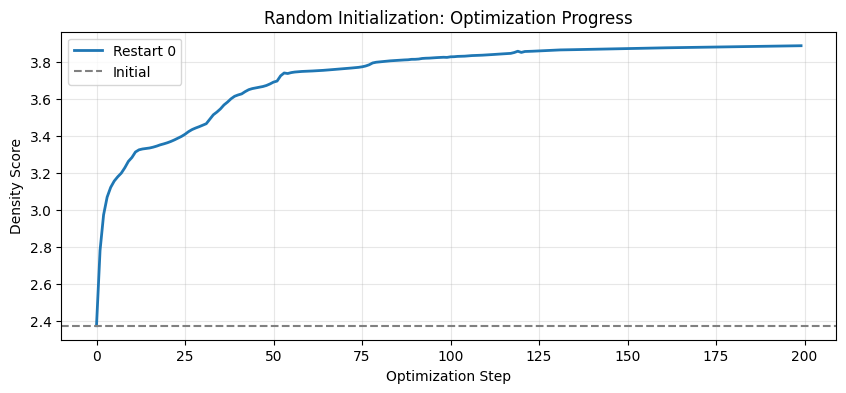

In [10]:
# new results
# Optimize from a random starting point
from torch import Tensor

seed_batch = merged[merged.density > 2.0].iloc[:1, :-1]
seed_batch = Tensor(seed_batch.values).to(device)

# New API returns OptimizationResult namedtuple with all details
result = model.optimize_latent(
    task_name="density",
    initial_input=seed_batch,
    mode="max",
    steps=200,
    lr=0.05,
    ae_task_name="reconstruction",
    optimize_space="input",  # Use input space optimization (default)
)

final_scores = result.optimized_target[0, :, 0].detach().cpu().numpy()
initial_scores = result.initial_score[0, 0, 0].detach().cpu().item()
print("Random Initialization Results:")
print(f"  Initial score: {initial_scores:.4f}")
print(f"  Optimized scores (per restart): {final_scores}")
print(f"  Best improvement: {final_scores.max() - initial_scores:+.4f}")

# Plot optimization trajectory for best restart
best_idx = int(final_scores.argmax())
traj = result.trajectory[0, best_idx, :, 0].detach().cpu().numpy()
plt.figure(figsize=(10, 4))
plt.plot(traj, linewidth=2, label=f'Restart {best_idx}')
plt.axhline(initial_scores, color='gray', linestyle='--', label='Initial')
plt.xlabel('Optimization Step')
plt.ylabel('Density Score')
plt.title('Random Initialization: Optimization Progress')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Random Initialization Results:
  Initial score: 2.3365
  Optimized scores (per restart): [2.532176]
  Best improvement: +0.1957


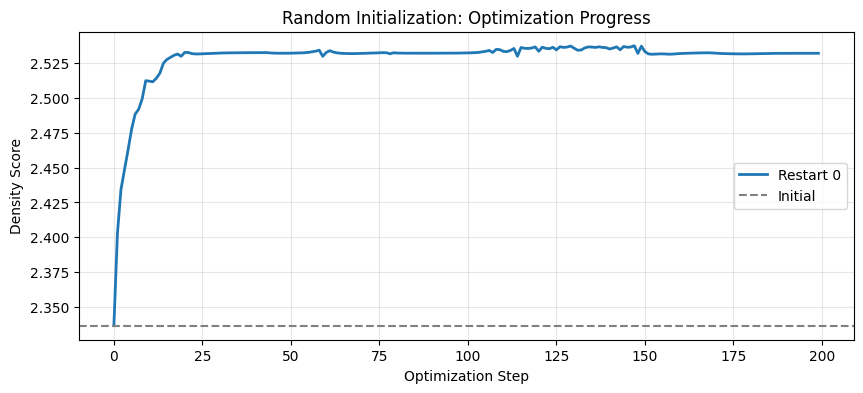

In [ ]:
# Old results
# Optimize from a random starting point
from torch import Tensor

seed_batch = merged[merged.density > 2.0].iloc[:1, :-1]
seed_batch = Tensor(seed_batch.values).to(device)

# New API returns OptimizationResult namedtuple with all details
result = model.optimize_latent(
    task_name="density",
    initial_input=seed_batch,
    mode="max",
    steps=200,
    lr=0.05,
    ae_task_name="reconstruction",
    optimize_space="input",  # Use input space optimization (default)
)

final_scores = result.optimized_target[0, :, 0].detach().cpu().numpy()
initial_scores = result.initial_score[0, 0, 0].detach().cpu().item()
print("Random Initialization Results:")
print(f"  Initial score: {initial_scores:.4f}")
print(f"  Optimized scores (per restart): {final_scores}")
print(f"  Best improvement: {final_scores.max() - initial_scores:+.4f}")

# Plot optimization trajectory for best restart
best_idx = int(final_scores.argmax())
traj = result.trajectory[0, best_idx, :, 0].detach().cpu().numpy()
plt.figure(figsize=(10, 4))
plt.plot(traj, linewidth=2, label=f'Restart {best_idx}')
plt.axhline(initial_scores, color='gray', linestyle='--', label='Initial')
plt.xlabel('Optimization Step')
plt.ylabel('Density Score')
plt.title('Random Initialization: Optimization Progress')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Strategy 2: Perturbation Around a Known Point

If you have a known good sample, add perturbation to explore the neighborhood.

Baseline sample score: 2.3745
Perturbation 0.00: Score = 3.8737, Improvement vs baseline = +1.4992
Perturbation 0.05: Score = 3.8856, Improvement vs baseline = +1.5111
Perturbation 0.10: Score = 3.9746, Improvement vs baseline = +1.6001
Perturbation 0.20: Score = 4.0036, Improvement vs baseline = +1.6291
Perturbation 0.50: Score = 3.9403, Improvement vs baseline = +1.5658


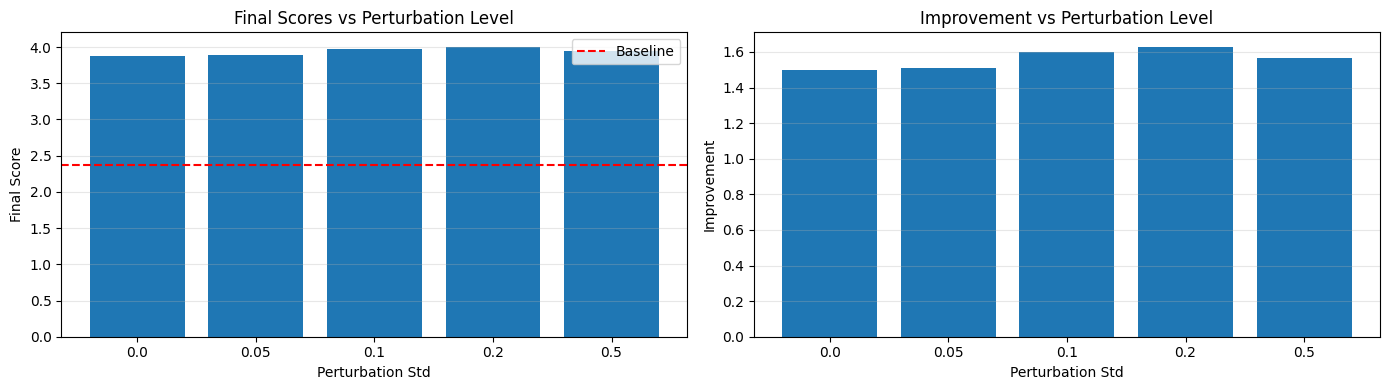

In [11]:
# Create a "known good sample" (from dataset)

with torch.no_grad():
    baseline_score = model(seed_batch)['density'].mean().item()

print(f"Baseline sample score: {baseline_score:.4f}")

perturbation_levels = [0.0, 0.05, 0.1, 0.2, 0.5]
results_perturbation = []

for perturb_std in perturbation_levels:
    result = model.optimize_latent(
        task_name="density",
        initial_input=seed_batch,
        mode="max",
        steps=200,
        perturbation_std=perturb_std,
        optimize_space="input",  # Default: optimize input space
    )
    final_score = result.optimized_target[0, 0, 0].item()
    results_perturbation.append({"perturbation": perturb_std, "final_score": final_score})
    print(f"Perturbation {perturb_std:.2f}: Score = {final_score:.4f}, Improvement vs baseline = {final_score - baseline_score:+.4f}")

df_perturb = pd.DataFrame(results_perturbation)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].bar(df_perturb['perturbation'].astype(str), df_perturb['final_score'])
axes[0].axhline(baseline_score, color='red', linestyle='--', label='Baseline')
axes[0].set_xlabel('Perturbation Std')
axes[0].set_ylabel('Final Score')
axes[0].set_title('Final Scores vs Perturbation Level')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(df_perturb['perturbation'].astype(str), df_perturb['final_score'] - baseline_score)
axes[1].axhline(0, color='gray', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Perturbation Std')
axes[1].set_ylabel('Improvement')
axes[1].set_title('Improvement vs Perturbation Level')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Strategy 3: Multi-Restart for Global Search

Try multiple random starts and pick the best result to avoid local optima.

Running optimization with 20 random restarts...
Best score: 3.9476 (restart 9)
Initial score: 1.9964
Statistics across 20 restarts:
  Score range: 3.8335 - 3.9476
  Mean score: 3.8903 ± 0.0348
  Best improvement: 1.9512


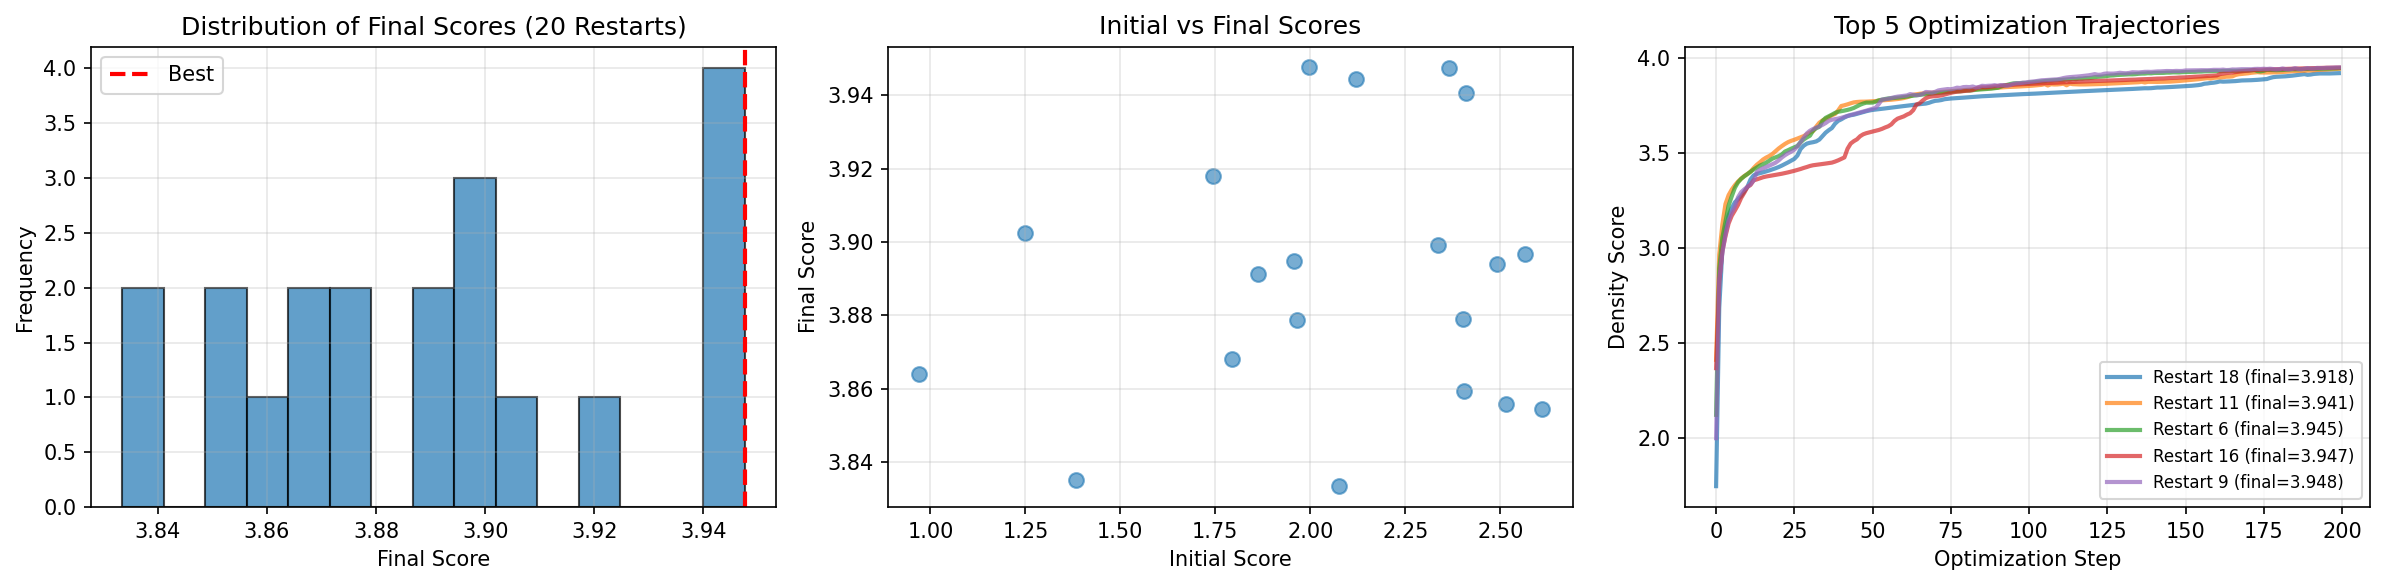

In [12]:
# Global search with multiple restarts
print("Running optimization with 20 random restarts...")

result = model.optimize_latent(
    task_name="density",
    initial_input=seed_batch,
    mode="max",
    steps=200,
    lr=0.05,
    num_restarts=20,
    perturbation_std=0.1,
    optimize_space="input",
)

scores = result.optimized_target[0, :, 0].detach().cpu().numpy()
initial_val = result.initial_score[0, :, 0].detach().cpu().numpy()
best_idx = int(scores.argmax())
print(f"Best score: {scores[best_idx]:.4f} (restart {best_idx})")
print(f"Initial score: {initial_val[best_idx]:.4f}")

print(f"Statistics across {len(scores)} restarts:")
print(f"  Score range: {scores.min():.4f} - {scores.max():.4f}")
print(f"  Mean score: {scores.mean():.4f} ± {scores.std():.4f}")
print(f"  Best improvement: {scores.max() - initial_val[best_idx]:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi=150)
axes[0].hist(scores, bins=15, alpha=0.7, edgecolor='black')
axes[0].axvline(scores[best_idx], color='red', linestyle='--', linewidth=2, label='Best')
axes[0].set_xlabel('Final Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Final Scores (20 Restarts)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(initial_val, scores, alpha=0.6, s=50)
axes[1].set_xlabel('Initial Score')
axes[1].set_ylabel('Final Score')
axes[1].set_title('Initial vs Final Scores')
axes[1].grid(alpha=0.3)

traj_multi = result.trajectory[0, :, :, 0].detach().cpu().numpy()  # (R, steps)
top_5 = np.argsort(scores)[-5:]
for idx in top_5:
    axes[2].plot(traj_multi[idx], alpha=0.7, linewidth=2, label=f"Restart {idx} (final={scores[idx]:.3f})")
axes[2].set_xlabel('Optimization Step')
axes[2].set_ylabel('Density Score')
axes[2].set_title('Top 5 Optimization Trajectories')
axes[2].legend(fontsize=8)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Analyzing the Reconstructed Descriptors

Let's compare the descriptors from different optimization strategies.

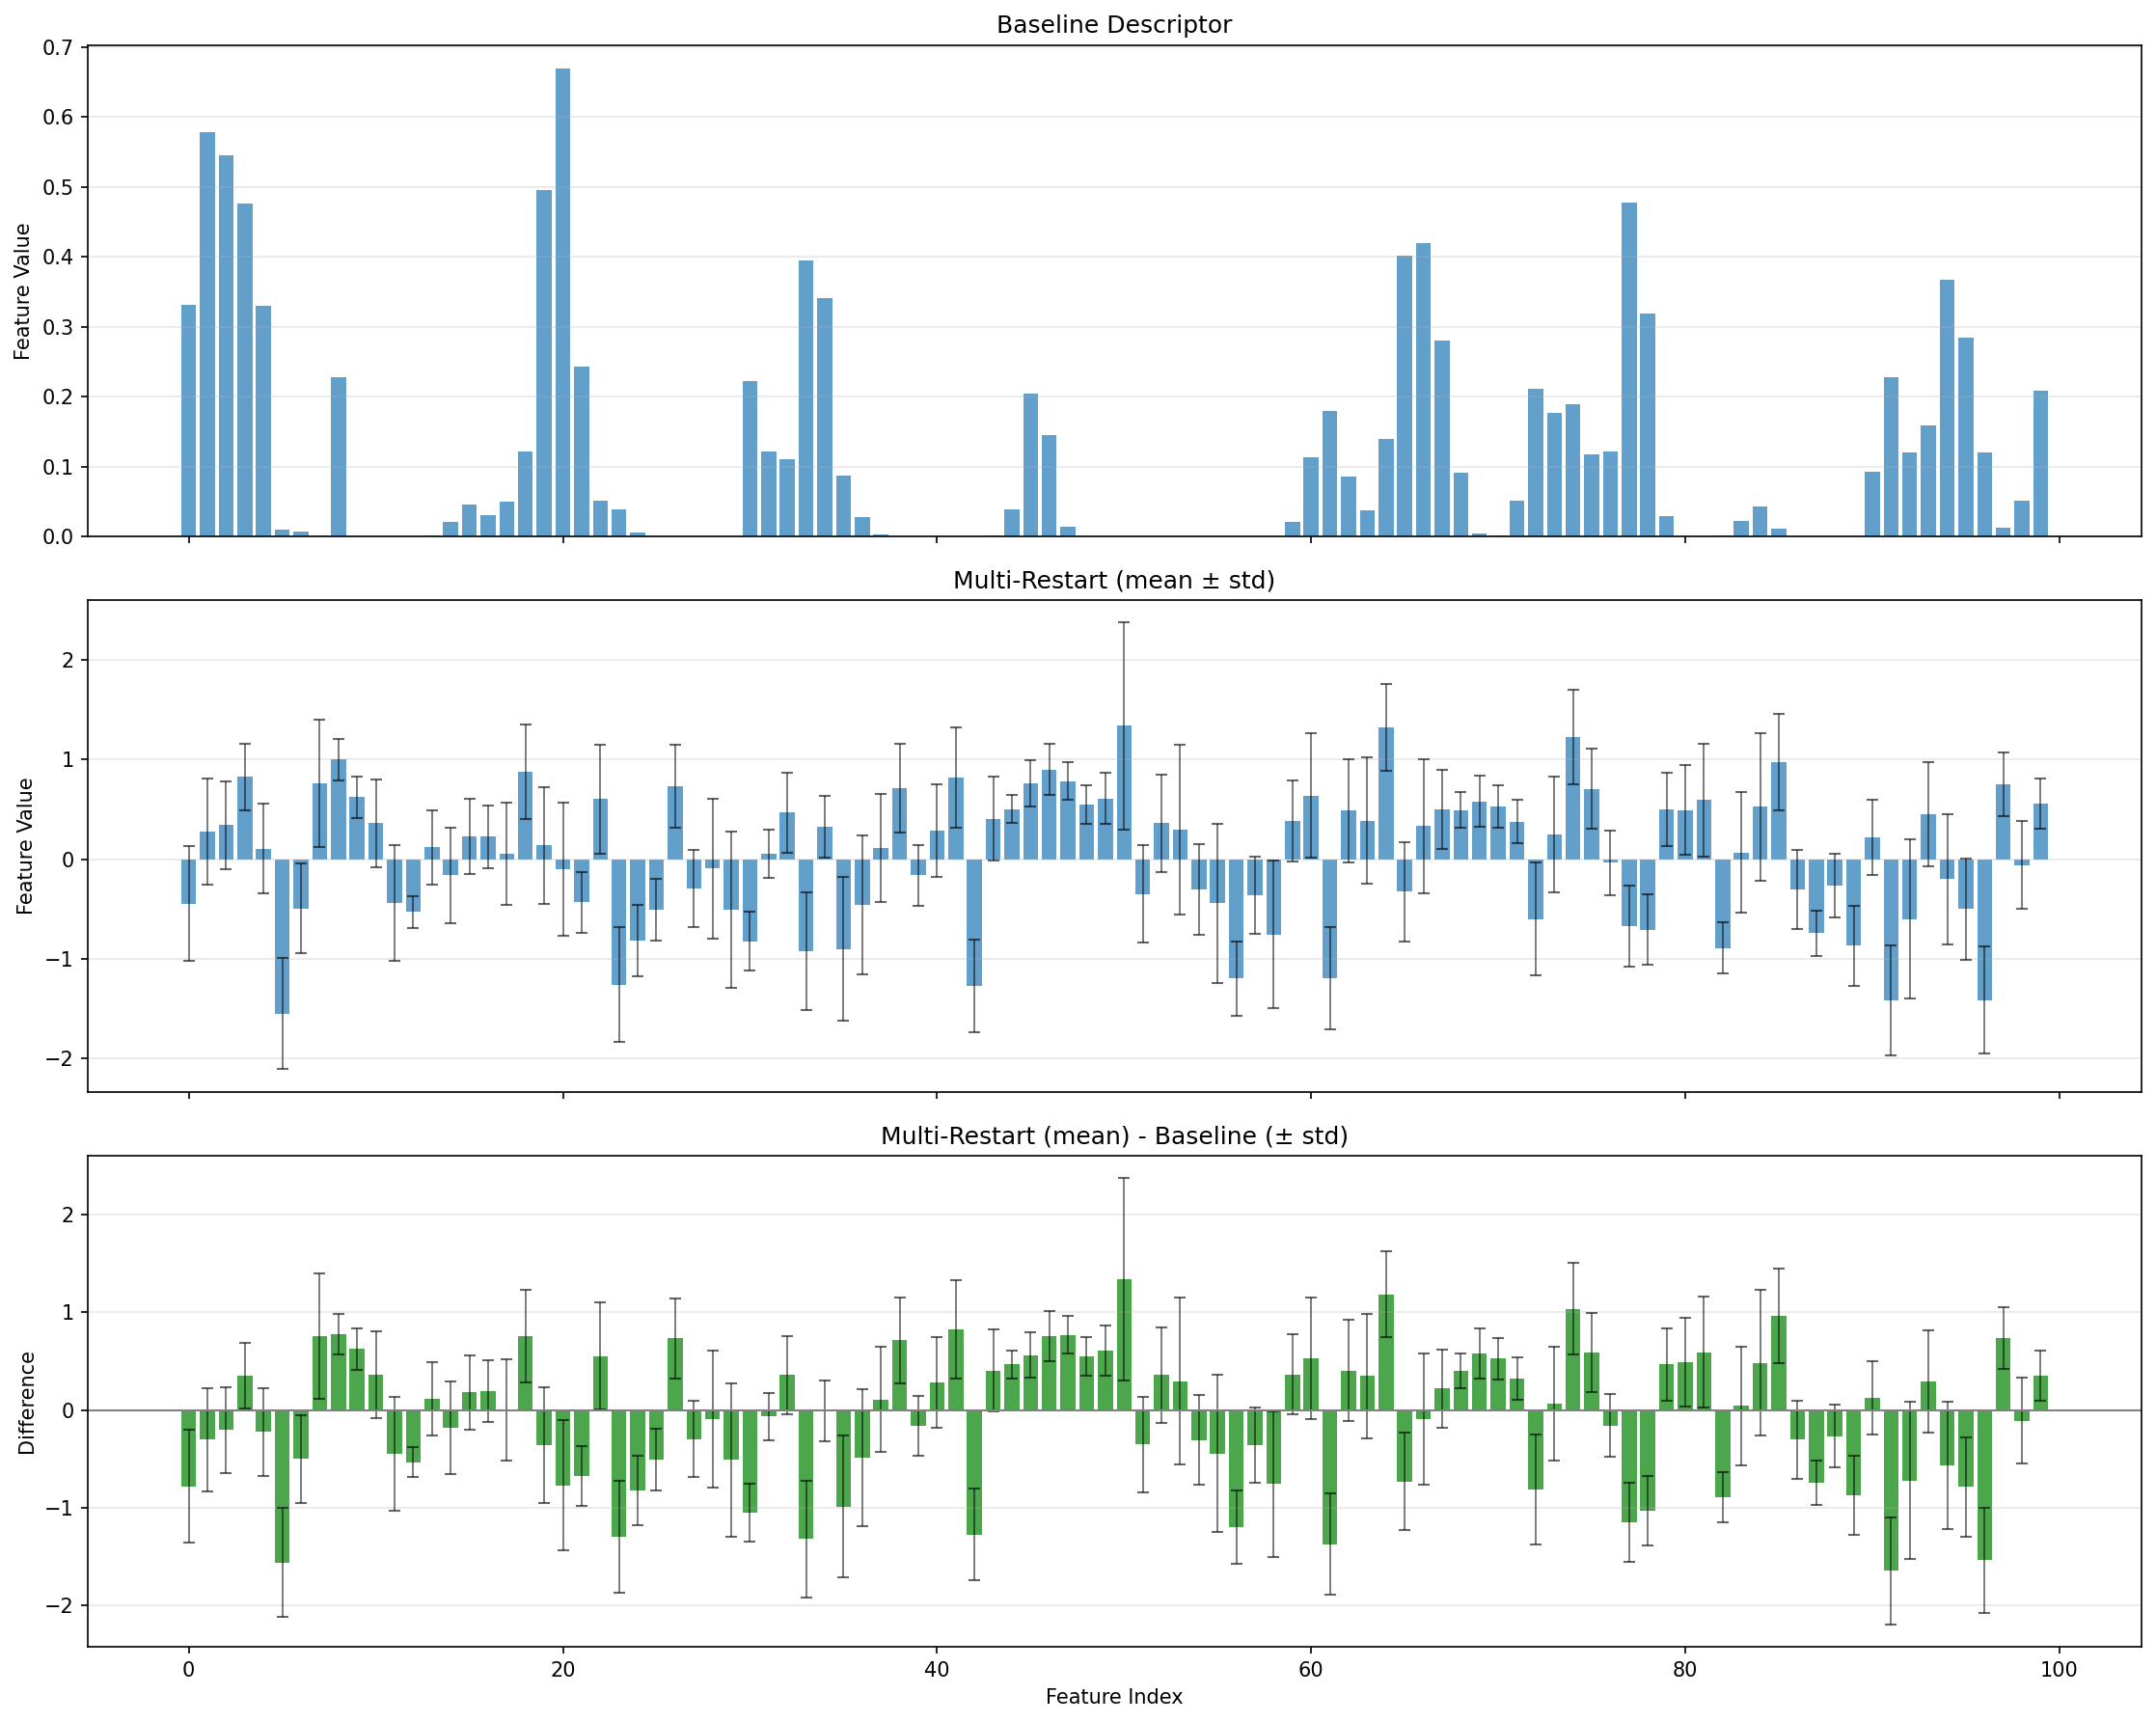

Descriptor statistics (first 100 features):
Baseline:
  Mean: 0.1118
  Std: 0.1558
  Range: [0.0000, 0.6697]
Multi-Restart (mean):
  Mean: 0.0341
  Std: 0.6605
  Range: [-1.5491, 1.3377]


In [13]:
# Get reconstructed/optimized descriptors (pick best restart from previous multi-restart run)
best_multi_idx = int(result.optimized_target[0, :, 0].argmax())

# Get reconstructed/optimized descriptors from all restarts
all_multi_descriptors = result.optimized_input[0].cpu().numpy()  # shape: (num_restarts, input_dim)

descriptors_ = {
    'Baseline': seed_batch[0].cpu().numpy().flatten(),
    'Multi-Restart (mean)': all_multi_descriptors.mean(axis=0),
}

# Visualize first n_show features with error bars
n_show = 100
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True, dpi=150)

# Baseline plot
axes[0].bar(range(n_show), descriptors_['Baseline'][:n_show], alpha=0.7)
axes[0].set_ylabel('Feature Value')
axes[0].set_title('Baseline Descriptor')
axes[0].grid(alpha=0.3, axis='y')

# Multi-restart mean with std as error bars
mean_vals = all_multi_descriptors.mean(axis=0)[:n_show]
std_vals = all_multi_descriptors.std(axis=0)[:n_show]
axes[1].bar(range(n_show), mean_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6})
axes[1].set_ylabel('Feature Value')
axes[1].set_title('Multi-Restart (mean ± std)')
axes[1].grid(alpha=0.3, axis='y')

# Difference: Multi-Restart (mean) - Baseline with error bars
diff_vals = mean_vals - descriptors_['Baseline'][:n_show]
axes[2].bar(range(n_show), diff_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6}, color='green')
axes[2].axhline(0, color='gray', linestyle='-', linewidth=1)
axes[2].set_xlabel('Feature Index')
axes[2].set_ylabel('Difference')
axes[2].set_title('Multi-Restart (mean) - Baseline (± std)')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical comparison
print('Descriptor statistics (first 100 features):')
for name, desc in descriptors_.items():
    print(f"{name}:")
    print(f"  Mean: {np.mean(desc[:n_show]):.4f}")
    print(f"  Std: {np.std(desc[:n_show]):.4f}")
    print(f"  Range: [{np.min(desc[:n_show]):.4f}, {np.max(desc[:n_show]):.4f}]")

## Strategy Comparison: Input Space vs Latent Space Optimization

The model supports two optimization strategies:

1. **Input Space Optimization** (`optimize_space="input"`):
   - Directly optimizes the high-dimensional input features X
   - The encoder is used in every forward pass
   - Tanh constraint is applied at the FlexibleMultiTaskModel level on every step
   - ✅ **Recommended for general use**
   
2. **Latent Space Optimization** (`optimize_space="latent"`):
   - Encodes X once to get initial latent representation
   - Directly optimizes the low-dimensional latent space
   - Tanh is applied uniformly (same as training) on every step
   - ✅ **Now properly constrained with unified Tanh architecture**
   - **Requires an autoencoder task** for reconstruction

Let's compare both approaches and analyze their behavior under the new simplified architecture.

In [14]:
# Comparison: Input Space vs Latent Space Optimization
print("=" * 80)
print("COMPARISON: Input Space vs Latent Space Optimization")
print("=" * 80)
print(f"Starting from baseline score: {baseline_score:.4f}\n")

# Common parameters
num_restarts_compare = 10
perturbation_std_compare = 0.1
steps_compare = 200
lr_compare = 0.05

# Strategy 1: Input Space Optimization
print("Running Input Space Optimization (optimize_space='input')...")
import time
start_time = time.time()
result_input = model.optimize_latent(
    task_name="density",
    initial_input=seed_batch,
    mode="max",
    steps=steps_compare,
    lr=lr_compare,
    num_restarts=num_restarts_compare,
    perturbation_std=perturbation_std_compare,
    optimize_space="input",
)
time_input = time.time() - start_time

scores_input = result_input.optimized_target[0, :, 0].detach().cpu().numpy()
initial_input = result_input.initial_score[0, :, 0].detach().cpu().numpy()

print(f"✓ Completed in {time_input:.2f}s")
print(f"  Best score: {scores_input.max():.4f}")
print(f"  Mean score: {scores_input.mean():.4f} ± {scores_input.std():.4f}")
print(f"  Best improvement: {scores_input.max() - initial_input.mean():.4f}\n")

# Strategy 2: Latent Space Optimization
print("Running Latent Space Optimization (optimize_space='latent')...")
start_time = time.time()
result_latent = model.optimize_latent(
    task_name="density",
    initial_input=seed_batch,
    mode="max",
    steps=steps_compare,
    lr=lr_compare,
    num_restarts=num_restarts_compare,
    perturbation_std=perturbation_std_compare,
    ae_task_name="reconstruction",
    optimize_space="latent",
)
time_latent = time.time() - start_time

scores_latent = result_latent.optimized_target[0, :, 0].detach().cpu().numpy()
initial_latent = result_latent.initial_score[0, :, 0].detach().cpu().numpy()

print(f"✓ Completed in {time_latent:.2f}s")
print(f"  Best score: {scores_latent.max():.4f}")
print(f"  Mean score: {scores_latent.mean():.4f} ± {scores_latent.std():.4f}")
print(f"  Best improvement: {scores_latent.max() - initial_latent.mean():.4f}\n")

# Summary comparison
print("=" * 80)
print("INITIAL COMPARISON RESULTS")
print("=" * 80)
print(f"Optimization space:  Input={input_dim}D, Latent={latent_dim}D")
print(f"Time ratio (latent/input): {time_latent/time_input:.2f}x")
print("Best score improvement:")
print(f"  Input Space:  {scores_input.max() - initial_input.mean():+.4f}")
print(f"  Latent Space: {scores_latent.max() - initial_latent.mean():+.4f}")
print("\n⚠️  WARNING: Latent space shows suspiciously high scores!")
print("    This suggests unbounded growth - let's investigate further below.")
print("=" * 80)

COMPARISON: Input Space vs Latent Space Optimization
Starting from baseline score: 2.3745

Running Input Space Optimization (optimize_space='input')...
✓ Completed in 1.01s
  Best score: 3.9603
  Mean score: 3.8929 ± 0.0543
  Best improvement: 1.8953

Running Latent Space Optimization (optimize_space='latent')...
✓ Completed in 0.53s
  Best score: 4.3748
  Mean score: 4.3736 ± 0.0010
  Best improvement: 2.0223

INITIAL COMPARISON RESULTS
Optimization space:  Input=190D, Latent=128D
Time ratio (latent/input): 0.52x
Best score improvement:
  Input Space:  +1.8953
  Latent Space: +2.0223

⚠️  WARNING: Latent space shows suspiciously high scores!
    This suggests unbounded growth - let's investigate further below.


/var/folders/rw/27164gts5x58ct1t2mtrnlrc0000gn/T/ipykernel_6972/864793192.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(data_boxplot, labels=['Input Space', 'Latent Space'], patch_artist=True)


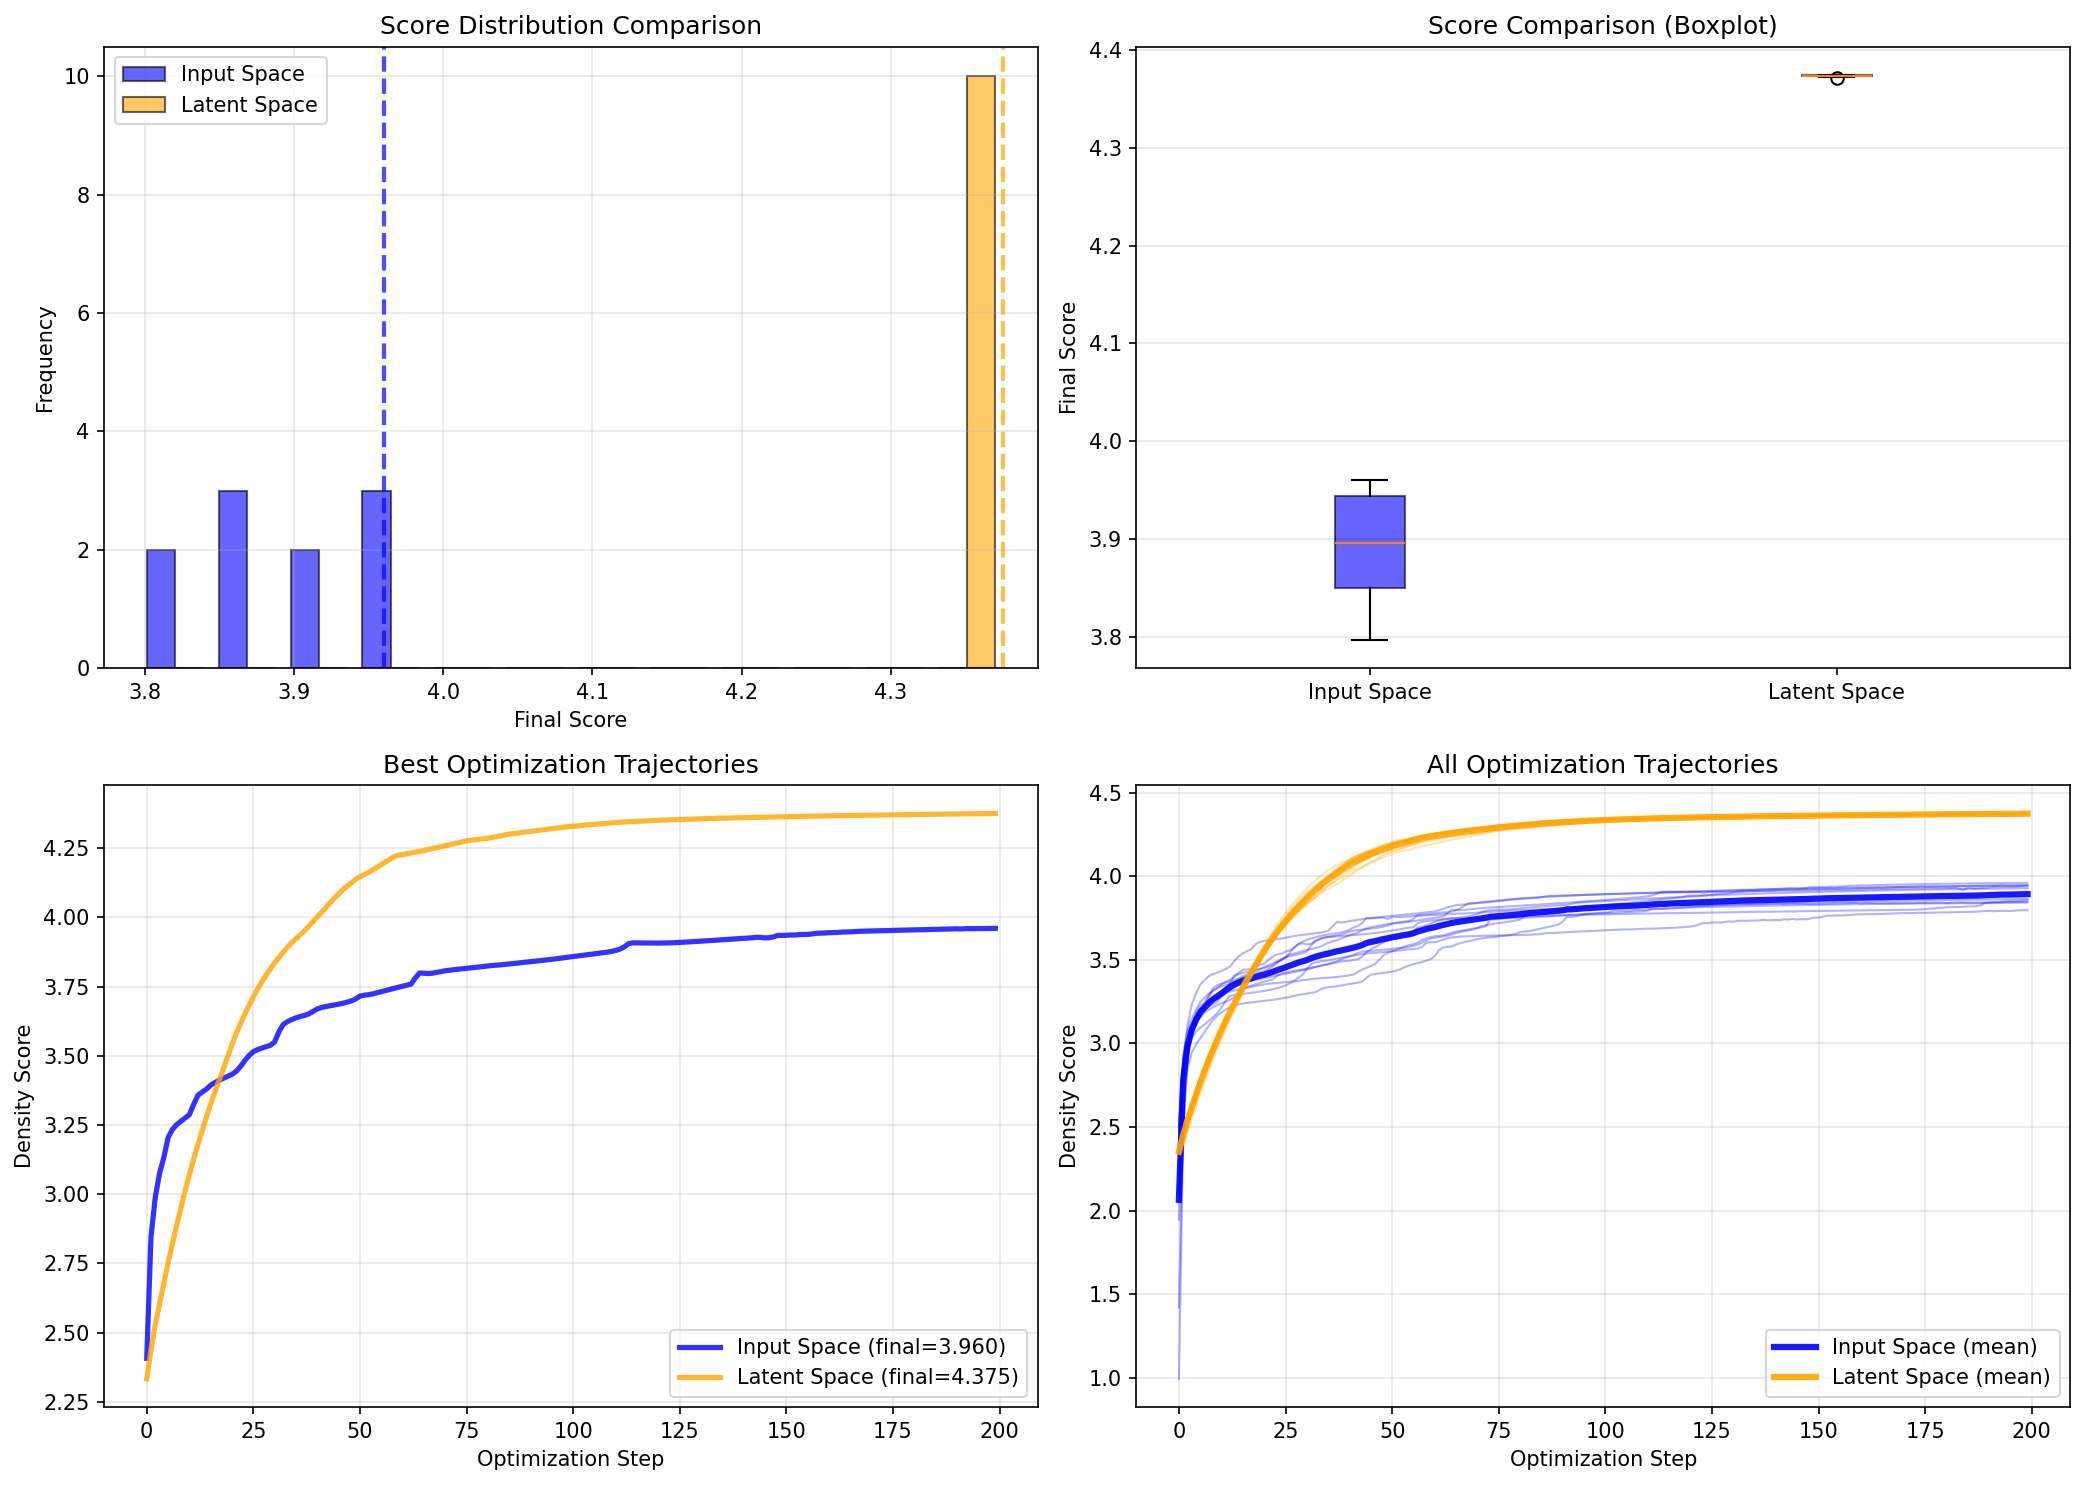


Reconstruction Quality Analysis:
Latent Space Optimization:
  Reconstruction MSE vs seed: 0.022819
  This measures how well the AE reconstructed the optimized latent back to input space

Tanh(latent) bounds verification:
  Input space:  [-1.0000, 1.0000] ✓
  Latent space: [-0.5215, 0.9998] ✓
  Both bounded to [-1, 1] as expected under unified Tanh architecture


In [15]:
# Visualize the comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=150)

# Plot 1: Score distributions
axes[0, 0].hist([scores_input, scores_latent], bins=12, alpha=0.6, label=['Input Space', 'Latent Space'],
                color=['blue', 'orange'], edgecolor='black')
axes[0, 0].axvline(scores_input.max(), color='blue', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 0].axvline(scores_latent.max(), color='orange', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Final Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Score Distribution Comparison')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Box plot comparison
data_boxplot = [scores_input, scores_latent]
bp = axes[0, 1].boxplot(data_boxplot, labels=['Input Space', 'Latent Space'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['blue', 'orange']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[0, 1].set_ylabel('Final Score')
axes[0, 1].set_title('Score Comparison (Boxplot)')
axes[0, 1].grid(alpha=0.3, axis='y')

# Plot 3: Optimization trajectories (best runs)
traj_input = result_input.trajectory[0, :, :, 0].detach().cpu().numpy()  # (R, steps)
traj_latent = result_latent.trajectory[0, :, :, 0].detach().cpu().numpy()  # (R, steps)

best_input_idx = int(scores_input.argmax())
best_latent_idx = int(scores_latent.argmax())

axes[1, 0].plot(traj_input[best_input_idx], linewidth=2.5, label=f'Input Space (final={scores_input[best_input_idx]:.3f})',
                color='blue', alpha=0.8)
axes[1, 0].plot(traj_latent[best_latent_idx], linewidth=2.5, label=f'Latent Space (final={scores_latent[best_latent_idx]:.3f})',
                color='orange', alpha=0.8)
axes[1, 0].set_xlabel('Optimization Step')
axes[1, 0].set_ylabel('Density Score')
axes[1, 0].set_title('Best Optimization Trajectories')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: All trajectories comparison
for idx in range(len(scores_input)):
    axes[1, 1].plot(traj_input[idx], alpha=0.3, color='blue', linewidth=1)
for idx in range(len(scores_latent)):
    axes[1, 1].plot(traj_latent[idx], alpha=0.3, color='orange', linewidth=1)

# Add mean trajectories
axes[1, 1].plot(traj_input.mean(axis=0), linewidth=3, color='blue', label='Input Space (mean)', alpha=0.9)
axes[1, 1].plot(traj_latent.mean(axis=0), linewidth=3, color='orange', label='Latent Space (mean)', alpha=0.9)
axes[1, 1].set_xlabel('Optimization Step')
axes[1, 1].set_ylabel('Density Score')
axes[1, 1].set_title('All Optimization Trajectories')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Reconstruction quality comparison
print("\nReconstruction Quality Analysis:")
print("=" * 60)

# For input space, we return the optimized input directly (no reconstruction needed)
# For latent space, we return AE-reconstructed input
with torch.no_grad():
    # Get best optimized inputs
    best_input_opt = result_input.optimized_input[0, best_input_idx:best_input_idx+1]
    best_latent_opt = result_latent.optimized_input[0, best_latent_idx:best_latent_idx+1]

    # Encode both and predict
    latent_from_input = model.encoder(best_input_opt)
    latent_from_latent_opt = model.encoder(best_latent_opt)

    # Check reconstruction error from latent space optimization
    # Note: best_latent_opt is already the AE-reconstructed input
    recon_error = F.mse_loss(best_latent_opt, seed_batch).item()

    print("Latent Space Optimization:")
    print(f"  Reconstruction MSE vs seed: {recon_error:.6f}")
    print("  This measures how well the AE reconstructed the optimized latent back to input space")
    
    # Verify Tanh bounds in both cases
    h_task_input = torch.tanh(latent_from_input)
    h_task_latent = torch.tanh(latent_from_latent_opt)
    
    print(f"\nTanh(latent) bounds verification:")
    print(f"  Input space:  [{h_task_input.min():.4f}, {h_task_input.max():.4f}] ✓")
    print(f"  Latent space: [{h_task_latent.min():.4f}, {h_task_latent.max():.4f}] ✓")
    print(f"  Both bounded to [-1, 1] as expected under unified Tanh architecture")

print("=" * 60)